<a href="https://colab.research.google.com/github/BaneleNyide/Projects/blob/main/Banele%2BVuyo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import math
import itertools
import numpy as np
import os
import random
import pickle
import cv2
from skimage import color
from keras.models import Sequential, load_model
from keras.layers import Conv1D, Activation, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import hog, local_binary_pattern
from google.colab.patches import cv2_imshow
from skimage.color import rgb2gray
import skimage
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis, skew
np.set_printoptions(threshold=np.inf)

In [2]:
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array,save_img
data_dir = 'imgs'
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
for file_name in os.listdir(data_dir):
    if file_name == ".DS_Store":
        continue
    img = load_img(os.path.join(data_dir, file_name))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)
    # Generate augmented images
    i = 0
    for batch in datagen.flow(img_array, batch_size=1):
        augmented_img = batch[0].astype('uint8')

        # Save the augmented image with a new name
        augmented_file_name = file_name.split('.')[0] + '_' + str(i) + '.' + file_name.split('.')[1]
        augmented_file_path = os.path.join(data_dir, augmented_file_name)
        save_img(augmented_file_path, augmented_img)

        i += 1
        if i >= 5:  # Generate 5 augmented images for each original image
            break  # Exit the loop after generating 5 augmented images

In [3]:

data_dir = 'imgs'
labels = ['R10', 'R20', 'R50', 'R100', 'R200']
data = []
width = 800
height = 500
import warnings
warnings.simplefilter("ignore")
def binarize(img, inferior_thresh, superior_thresh):
    _, binary_img = cv2.threshold(img, inferior_thresh, superior_thresh, cv2.THRESH_BINARY)
    return binary_img

def edgeDetection(img):
    edges = cv2.Canny(img, 50, 100, apertureSize=3)
    return edges

def applyFilters(img,isExample=False):
    img = cv2.resize(img, (width, height))
    if isExample:
        print("Original Image")
        cv2_imshow(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    if img.ndim > 2:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      if isExample:
        print("Gray Scale Image")
        cv2_imshow(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    if isExample:
        print("Gaussian Filtered Image")
        cv2_imshow(blurred)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    blurred = cv2.equalizeHist(blurred)
    if isExample:
        print("Image After Histogram Equalization")
        cv2_imshow(blurred)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    binary_img = binarize(blurred, 130, 255)
    if isExample:
        print("Image After Thresholding")
        cv2_imshow(blurred)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    cnts = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    h, w = img.shape[:2]
    dst = np.zeros((h, w, 3), np.uint8)
    for c in cnts:
        cv2.drawContours(dst, [c], 0, (255, 255, 255), 1)
    if isExample:
        print("Image After Edge Detection")
        cv2_imshow(dst)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return dst

# Function to extract all features
def extract_features(img):
    feature_vector = []
    if img.ndim > 2:
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img

    # 1. Histogram of Oriented Gradients (HOG)
    hog_features = skimage.feature.hog(img_gray, pixels_per_cell=(32, 32), cells_per_block=(1, 1), multichannel=False)
    feature_vector.extend(hog_features[:10])

    # 2. Local Binary Patterns (LBP)
    radius = 1
    n_points = 8 * radius
    lbp = skimage.feature.local_binary_pattern(img_gray, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    feature_vector.extend(hist[:10])

    # 3. Shape Features
    contours, _ = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h if h != 0 else 0.0
        feature_vector.extend([area, perimeter, aspect_ratio])
        break  # Only use the largest contour
    # 4. Texture Features
    gray = img if len(img.shape) == 2 else rgb2gray(img)
    glcm = skimage.feature.graycomatrix(gray, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = skimage.feature.graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = skimage.feature.graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = skimage.feature.graycoprops(glcm, 'homogeneity')[0, 0]
    ASM = skimage.feature.graycoprops(glcm, 'ASM')[0, 0]
    energy = skimage.feature.graycoprops(glcm, 'energy')[0, 0]
    correlation = skimage.feature.graycoprops(glcm, 'correlation')[0, 0]
    feature_vector.extend([contrast, dissimilarity, homogeneity, ASM, energy, correlation])
    return feature_vector

def create_dataset():
    training_data = []
    for file_name in os.listdir(data_dir):
        if file_name == ".DS_Store":
            continue
        label = ''
        try:
            index = file_name.index('(')
            label = 'R' + file_name[0:index]
        except ValueError:
            index = file_name.index('.')
            label = 'R' + file_name[0:index]
        if label not in labels or file_name.split('.')[-1] not in ['jpg', 'jpeg', 'bmp', 'png']:
            continue
        path = os.path.join(data_dir, file_name)
        image = cv2.imread(path)
        image = cv2.resize(image, (width, height))
        image = edgeDetection(applyFilters(image))
        feature_vec = extract_features(image)
        if feature_vec is not None:
            label_integer = int(label[label.index("R") + 1:])
            training_data.append([feature_vec, label_integer])
        else:
          training_data.append(np.zeros(29))

    print("Dataset created")
    return training_data

# Create dataset
training_data = create_dataset()
# Prepare features and labels
X = [feature for feature, label in training_data]
y = [label for feature, label in training_data]
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


# # Train SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# # Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")



Dataset created
Accuracy: 34.44%


Original Image


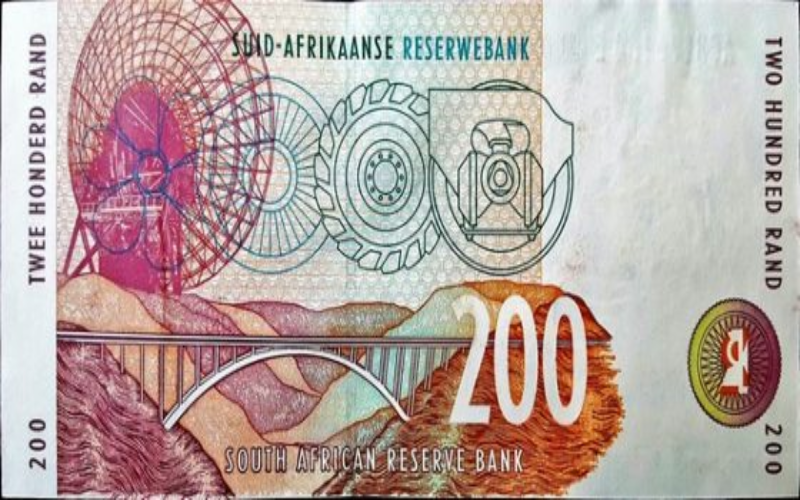

Gray Scale Image


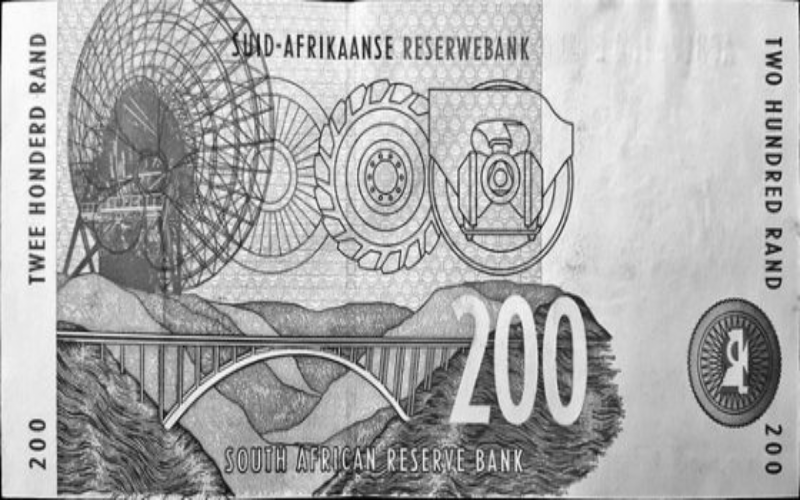

Gaussian Filtered Image


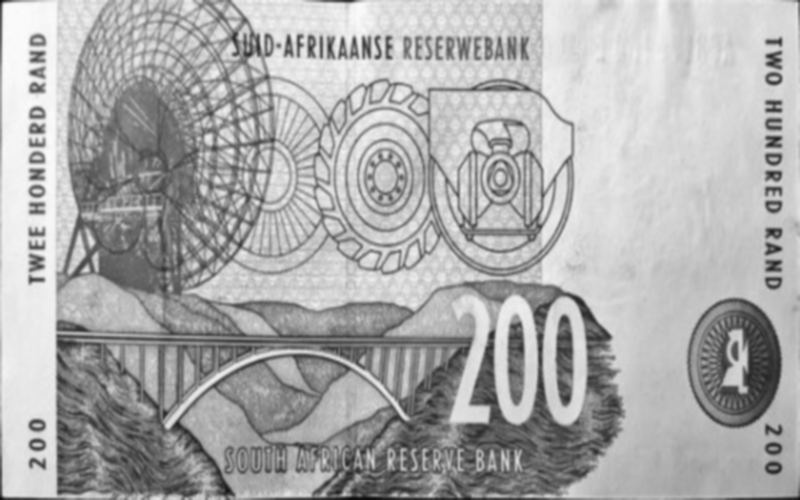

Image After Histogram Equalization


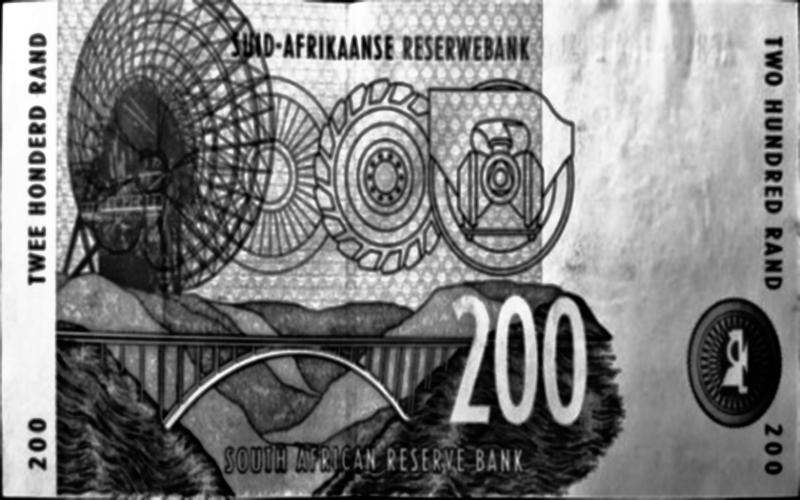

Image After Thresholding


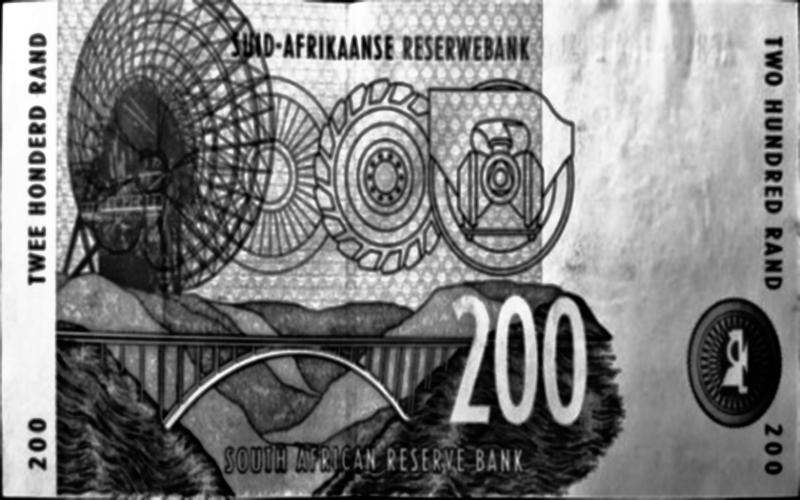

Image After Edge Detection


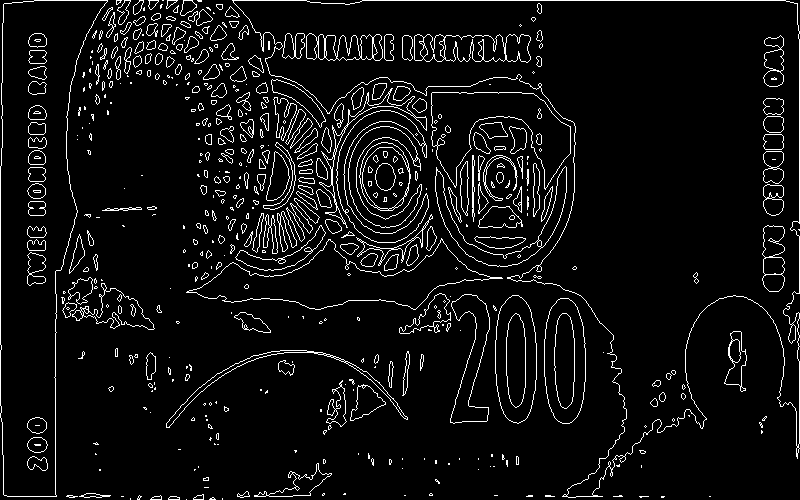

Predicted Class By SVM For This Bank Note: R20


In [4]:
new_img = cv2.imread('imgs/200(7).jpg')
new_img = cv2.resize(new_img, (width, height))
preprocessed_new_img = applyFilters(new_img,True)
segmented_new_img = edgeDetection(preprocessed_new_img)
new_img_descriptors = extract_features(segmented_new_img)

# # Prepare new image descriptors for prediction
new_img_descriptors = np.array(new_img_descriptors).reshape(1, -1)
new_img_descriptors = scaler.transform(new_img_descriptors)
new_predictions = clf.predict(new_img_descriptors)
new_prediction = max(set(new_predictions), key=new_predictions.tolist().count)

print(f"Predicted Class By SVM For This Bank Note: R{new_prediction}")


In [5]:
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Map labels to indices
label_to_index = {10: 0, 20: 1, 50: 2, 100: 3, 200: 4}
index_to_label = {v: k for k, v in label_to_index.items()}

y_mapped = [label_to_index[label] for label in y]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.15, random_state=42)

# Convert labels to one-hot encoded format
num_classes = 5
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Reshape the feature vectors to fit the input shape of the CNN model
X_train = np.array(X_train).reshape(-1, 29, 1)
X_test = np.array(X_test).reshape(-1, 29, 1)

# Split the training data into training and validation sets
X_train, X_val, y_train_one_hot, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(29, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val), epochs=20, batch_size=15)
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


Epoch 1/20
28/28 [==============================] - 2s 19ms/step - loss: 1.5510 - accuracy: 0.2917 - val_loss: 1.5524 - val_accuracy: 0.2941
Epoch 2/20
28/28 [==============================] - 0s 7ms/step - loss: 1.4372 - accuracy: 0.3873 - val_loss: 1.5397 - val_accuracy: 0.3431
Epoch 3/20
28/28 [==============================] - 0s 6ms/step - loss: 1.4003 - accuracy: 0.4510 - val_loss: 1.5231 - val_accuracy: 0.3431
Epoch 4/20
28/28 [==============================] - 0s 6ms/step - loss: 1.3677 - accuracy: 0.4363 - val_loss: 1.5114 - val_accuracy: 0.4118
Epoch 5/20
28/28 [==============================] - 0s 8ms/step - loss: 1.3318 - accuracy: 0.4632 - val_loss: 1.5122 - val_accuracy: 0.3431
Epoch 6/20
28/28 [==============================] - 0s 7ms/step - loss: 1.3402 - accuracy: 0.4314 - val_loss: 1.4982 - val_accuracy: 0.3725
Epoch 7/20
28/28 [==============================] - 0s 7ms/step - loss: 1.2907 - accuracy: 0.4951 - val_loss: 1.4772 - val_accuracy: 0.3529
Epoch 8/20
28/28 [=